In [9]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Input, Conv1D, Conv2D, MaxPooling2D, BatchNormalization, Dense
from keras.models import Model
import multiprocessing as mp
from scipy.ndimage import convolve

from CNN_functions import create_plans, stack_plans, build_dataset
#import CNN_functions as cnnf

%matplotlib inline

Size of plan is  (63, 100, 100) , with  1879  neurons. Computed in  2.6187727451324463  seconds.


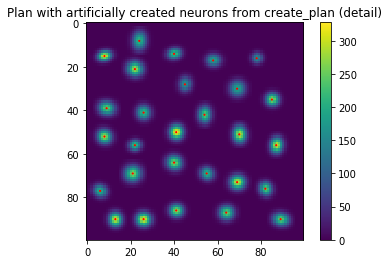

In [10]:
# Common to all plans
dim_plan_pix = np.array([100, 100])
# Neurons characteristics
cov_mean = 0
cov_std = 0.2
xvar_mean = 4.5
xvar_std = 1
yvar_mean = 4.5
yvar_std = 1
# Matrix for plans
planpar = np.array([[250, 150, 100], #, 15], # value for neurons
                    [50, 30, 20], #, 4], # variance for value for neurons
                    [3, 35, 25], #, 37], # repartitions of values for neurons 
                    [40, 60, 60], #, 15], # mean number of neurons per plan
                    [3, 5, 5]]) #, 5]]) # std for number of neurons per plan

# Building first empty matrices
plan_sketch = np.zeros((0, dim_plan_pix[0], dim_plan_pix[1]))
coord_sketch = np.zeros((0, 3))

# Launching for-loop
ti = time.time()
for i in range(planpar.shape[1]):
    plannum = planpar[2, i]
    numneur = planpar[3, i]
    numstd = planpar[4, i]
    info_neuron = planpar[0, i], planpar[1, i], cov_mean, cov_std, xvar_mean, xvar_std, yvar_mean, yvar_std
    plan_sketch_temp, coord_sketch_temp = create_plans(plannum, dim_plan_pix, numneur, numstd, info_neuron)
    len_plan_sketch = plan_sketch.shape[0]
    coord_sketch_temp[:, 0] += len_plan_sketch
    plan_sketch = np.concatenate((plan_sketch, plan_sketch_temp), axis=0)
    coord_sketch = np.vstack((coord_sketch, coord_sketch_temp))
tf = time.time() - ti

print("Size of plan is ", plan_sketch.shape, ", with ", coord_sketch.shape[0], " neurons. Computed in ", tf, " seconds.")

# Example to plot
example = 0
# Plotting original neurons
plt.imshow(plan_sketch[example, :, :])
plt.colorbar()
plt.title("Plan with artificially created neurons from create_plan (detail)")
# Adding centers of neurons
coord_sketch2 = coord_sketch[coord_sketch[:, 0] == example, 1:3]
plt.scatter(coord_sketch2[:, 1], coord_sketch2[:, 0], s=5, c=[1, 0, 0]*np.ones((coord_sketch2.shape[0], 1)), marker='.')

Size of sk_plans is  (1000, 40, 40) , and there are  32280  neurons. Computed in  0.8282511234283447  seconds.


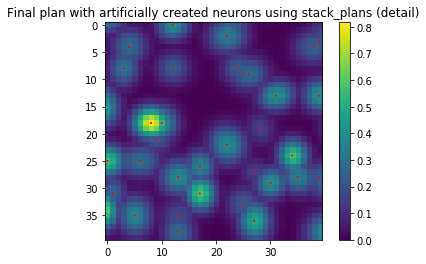

In [11]:
# Building plans based on plan_sketch and coord_sketch
# Parameters
nstacks = 1000
stk_mean = 6
stk_std = 2
crop_size = 40
noise_mean = 0
noise_std = 0

# Launching for-loop
ti = time.time()
sk_plans, sk_coord = stack_plans(nstacks, plan_sketch, coord_sketch, crop_size, stk_mean, stk_std, noise_mean, noise_std)
# NORMALIZING SK_PLAN
sk_plans = sk_plans / np.max(sk_plans)
tf = time.time() - ti

print("Size of sk_plans is ", sk_plans.shape, ", and there are ", sk_coord.shape[0], " neurons. Computed in ", tf, " seconds.")

# Plotting random stack with pointers for neuron centers
example = 0
# Plotting original neurons
plt.imshow(sk_plans[example, :, :])
plt.colorbar()
plt.title("Final plan with artificially created neurons using stack_plans (detail)")
# Adding centers of neurons
sk_coord2 = sk_coord[sk_coord[:, 0] == example, 1:3]
plt.scatter(sk_coord2[:, 1], sk_coord2[:, 0], s=5, c=[1, 0, 0]*np.ones((sk_coord2.shape[0], 1)), marker='.')

In [12]:
# Buildind dataset
training_proportion = 0.8
ti = time.time()
Xtrain, Ytrain, Xtest, Ytest = build_dataset(sk_plans, sk_coord, training_proportion)
tf = time.time() - ti

print("Size of training set is ", Xtrain.shape, Ytrain.shape, ", test set is ", Xtest.shape, Ytest.shape, ". Computed in ", tf, " seconds.")

# Rearranging to CNN architecture
# Reshaping
Xtrain = Xtrain.reshape(Xtrain.shape[0], crop_size, crop_size, 1)
Ytrain = Ytrain.reshape(Ytrain.shape[0], 1, 1, crop_size*crop_size)
Xtest = Xtest.reshape(Xtest.shape[0], crop_size, crop_size, 1)
Ytest = Ytest.reshape(Ytest.shape[0], 1, 1, crop_size*crop_size)

print("New sizes for training set are ", Xtrain.shape, Ytrain.shape, " test set are ", Xtest.shape, Ytest.shape)

Size of training set is  (800, 40, 40) (800, 1600) , test set is  (200, 40, 40) (200, 1600) . Computed in  4.126574516296387  seconds.
New sizes for training set are  (800, 40, 40, 1) (800, 1, 1, 1600)  test set are  (200, 40, 40, 1) (200, 1, 1, 1600)


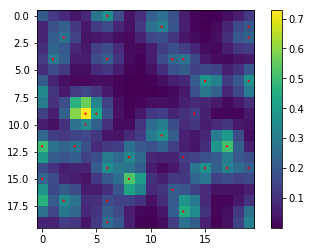

In [26]:
temp = sk_plans[0, :, :]
blow = int(np.floor(crop_size/2))
plans = np.zeros((blow, blow))
for i in range(blow):
    for j in range(blow):
        plans[i, j] = np.mean(temp[2*i:(2*i+2), 2*j:(2*j+2)])
coord = sk_coord[sk_coord[:, 0] == 0, :]
coord = np.floor(coord / 2)
plt.imshow(plans)
plt.colorbar()

plt.scatter(coord[:, 2], coord[:, 1], s=5, c=[1, 0, 0]*np.ones((coord.shape[0], 1)), marker='.')